# Tutorial Episode 2: Ignoring noise

In this notebook, I show you how to use some experimental features that help you ignore the contributions of noise.

In [1]:
import os
import sys
sys.path.append(os.path.pardir)

%matplotlib inline
import numpy as np

from fa_kit import FactorAnalysis
from fa_kit import plotting as fa_plotting

## Synthesizing fake data

Making fake data and putting it into a DataFrame, `df_data`, just like Episode 1.

In [2]:
import pandas as pd
import string

def make_random_data(n_samp=10000, n_feat=100):
    """
    make some random data with correlated features
    """
    data = np.random.randn(n_samp, n_feat)
    
    signal_width = 10
    signal_overlap = 2
    step_size = signal_width - signal_overlap
    for i in range(0, data.shape[1], step_size):
        shared_signal = 0.3*np.random.randn(n_samp, 1)
        data[:, i:(i+signal_width)] += shared_signal
    return data

data = make_random_data()

column_names = [
    "{}{}".format(i, string.lowercase[i % len(string.lowercase)])
    for i in range(data.shape[1])]

df_data = pd.DataFrame(
    data,
    columns=column_names
    )


## Setting up a factor analysis pipeline

The function `run_pipeline` will take a set of data and run through each of the steps in a factor analysis.

Except now, the extra argument is whether you pass in a second matrix that describes the covariance structure of noise in your dataset. If you leave is as `None`, you'll just do a normal analysis by extracting the eigenvectors from a correlation/covariance matrix. But if you pass in a second `n_features-by-n_features` noise matrix, we'll switch over to an solving the [Generalized Eigenvalue Problem](http://fourier.eng.hmc.edu/e161/lectures/algebra/node7.html).

In the normal eigendecomposition, the components you extract are constructed to maximize the total amount of variation they can explain in the data. In the Generalized Eigenvalue Problem, they are constructed to maximize the ratio of (variation explained in `A`) / (variation explained in `B`). This can be useful if `B` is a 'noise' matrix that explains patterns you'd like to ignore (*e.g.*, within-group variability, or measurements of intrumentation noise).

So in this example, we show how you can steer your solution away from 'noise' by passing in a noise covariance matrix.

**Warning:** this feature is still under development. it might get a little weird.

*Also Note:* If you try to find the correct number of components to keep using the broken stick distribution, it won't work right. I've decided to clamp the retention at the vales corresponding to the natual dropoffs in the scree plots rather than cherry-pick a noise regime where everything just-so-happens to look good with my broken-stick.

In [3]:
def run_pipeline(data, noise_cov=None, num_to_keep=12, **kwargs):

    fa = FactorAnalysis.load_data_samples(
        data,
        preproc_demean=True,
        preproc_scale=True,
        **kwargs
        )

    if noise_cov is not None:
        fa.add_noise_cov(noise_cov)
    
    fa.extract_components()

    fa.find_comps_to_retain(
        'top_n',
        num_keep=num_to_keep,
        **kwargs
        )

    fa.reextract_using_paf()

    # Apply factor rotation
    # Right now there are both 'varimax' and 'quartimax'
    fa.rotate_components(
        method='varimax'
        )

    return fa

### Demo: Normal, not steering away from noise

You've seen this in the previous two episodes. It's just here to make comparisons easier

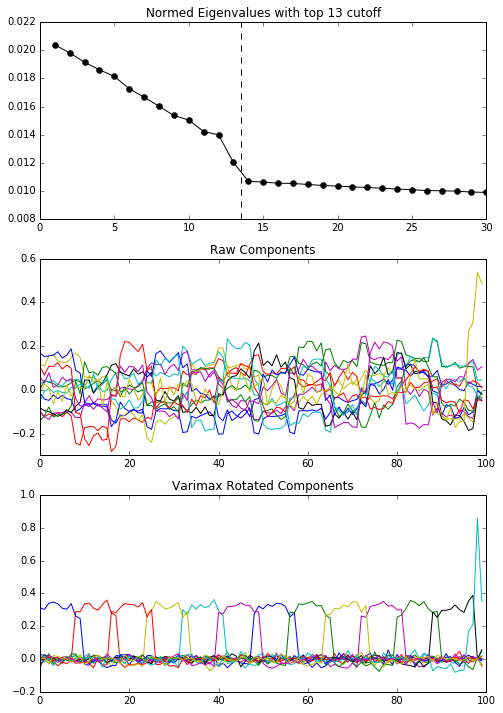

In [4]:
fa_1 = run_pipeline(df_data, num_to_keep=13)
fig = fa_plotting.graph_summary(fa_1)

### Demo: Steering components away from explaining noise.

We make a sample noise matrix, `noise_cov` that assumes every dimension has independent noise, and the first 50 features has low-noise and the second 50 features have high noise, so we just put those low/high noise values along the diagonal.

Then we pass that noise matrix into the analysis, and we see that the solution is steered away (quite dramatically) from explaining variability in the high-noise components.

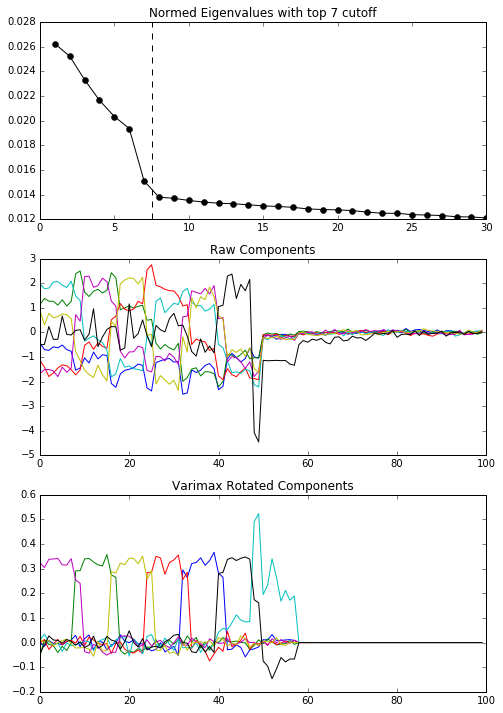

In [5]:
noise = np.std(data, axis=0)
for i in range(len(noise)):
    if i < 50:
        noise[i] = 0.01
    else:
        noise[i] = 0.02
noise_cov = np.diag(noise)

fa_2 = run_pipeline(df_data, noise_cov=noise_cov, num_to_keep=7)
fig = fa_plotting.graph_summary(fa_2)